# Export d2go model trained in coco2017 to torchscript_int8

This notebook creates a d2go model for use in the [flutter_d2go](https://pub.dev/packages/flutter_d2go) [example app](https://github.com/tsubauaaa/flutter_d2go/tree/master/example). The d2go models created in this notebook can be used in [flutter_d2go](https://pub.dev/packages/flutter_d2go).

## Confirmation of torch environment
Assumes torch 1.11.0+cu113 on Google Colab Pro as of July 2022

In [1]:
!python -c 'import torch; print(torch.__version__, torch.cuda.is_available())'

1.11.0+cu113 True


## Installation

### Install detectron2
Restart the runtime when install is finished.

In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-54_ce3up
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-54_ce3up
     |████████████████████████████████| 50 kB 3.7 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 151 kB 47.8 MB/s 
     |████████████████████████████████| 1.4 MB 16.7 MB/s 
     |████████████████████████████████| 431 kB 38.4 MB/s 
     |████████████████████████████████| 248 kB 47.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 5.8 MB/s 
     |████████████████████████████████| 843 kB 50.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████

### Install mobile-vision

In [1]:
!pip install 'git+https://github.com/facebookresearch/mobile-vision.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/mobile-vision.git to /tmp/pip-req-build-1ypv3cve
  Running command git clone -q https://github.com/facebookresearch/mobile-vision.git /tmp/pip-req-build-1ypv3cve
     |████████████████████████████████| 44 kB 2.4 MB/s 
  Created wheel for mobile-cv: filename=mobile_cv-0.1-py3-none-any.whl size=244088 sha256=a5c1b6913fda3a0b3d9ec437e3facf15f05b6f5efa9f51a2fc387c967ac9da38
  Stored in directory: /tmp/pip-ephem-wheel-cache-cwaz_5ag/wheels/a1/cd/50/a0ceb1cce88c16740b4d782a587c1d21f79a8f9567129919bf
Successfully built mobile-cv


### Install d2go

In [2]:
!git clone https://github.com/facebookresearch/d2go.git
%cd d2go
!pip install .
%cd /content

Cloning into 'd2go'...
remote: Enumerating objects: 3347, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 3347 (delta 105), reused 178 (delta 97), pack-reused 3144
Receiving objects: 100% (3347/3347), 2.71 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (2278/2278), done.
/content/d2go
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/d2go
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Cloning https://github.com/PyTorchLightning/pytorch-lightning (to revision 9b011606f) to /tmp/pip-install-0oi2diem/pytorc

## Inference with Pre-trained Models

In this section, we will show how to load pretrained models using d2go model_zoo API, and how to make predictions with d2go models and visualize the output. 

- First import the model zoo API from d2go and get a pretrained Faster R-CNN model with FBNetV3 backbone

In [3]:
!cp -pr d2go/configs /usr/local/lib/python3.7/dist-packages/d2go/

If, at runtime, you get the following error in d2go/runner/api.py

```
ImportError: cannot import name 'final' from 'typing' (/usr/lib/python3.7/typing.py)```

Please take the following actions.
- Comment out lines 4 and 17 of d2go/runner/api.py

In [5]:
from d2go.model_zoo import model_zoo
model = model_zoo.get("faster_rcnn_fbnetv3a_C4.yaml", trained=True)

INFO:d2go.modeling.backbone.fbnet_v2:Using un-unified arch_def for ARCH "FBNetV3_A" (without scaling):
trunk
- [('conv_k3', 16, 2, 1), ('ir_k3', 16, 1, 2, {'expansion': 1}, {'less_se_channels': False})]
- [('ir_k5', 24, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 24, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5_se', 32, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 32, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5', 64, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 64, 1, 3, {'expansion': 3}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
rpn
- [('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
bbox
- [('ir_k5_se', 184, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 184, 1, 4, {'expansion': 4}, {'less_se_channels': False}),

- Download an image from the COCO dataset:

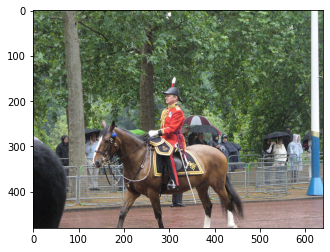

In [6]:
import cv2
from matplotlib import pyplot as plt
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

- Then we can create a `DemoPredictor` to run inference on this image and see the raw outputs:

In [7]:
from d2go.utils.demo_predictor import DemoPredictor
predictor = DemoPredictor(model)
outputs = predictor(im)
# the output object categories and corresponding bounding boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0, 17, 17, 17,  0, 20, 19,  0, 17, 20, 17, 22, 19, 19, 19],
       device='cuda:0')
Boxes(tensor([[123.8110, 241.3701, 479.6925, 480.0000],
        [276.2808, 147.8153, 365.5569, 400.5892],
        [ 51.7697, 279.1486,  78.7433, 341.4369],
        [504.6472, 261.5977, 587.4645, 335.1068],
        [331.7795, 234.2217, 410.3190, 307.9734],
        [408.7299, 285.3493, 462.2014, 353.3683],
        [  2.9709, 277.4142,  75.1721, 476.9531],
        [  3.1935, 277.9557,  75.0488, 476.4275],
        [504.8674, 262.9518, 592.4091, 339.0173],
        [556.2568, 270.3552, 595.2379, 355.6459],
        [  3.2859, 277.9533,  75.0428, 476.7831],
        [504.8312, 262.8539, 587.5267, 330.3096],
        [555.7526, 280.5878, 595.2996, 360.6277],
        [555.3569, 279.8503, 595.3765, 360.5094],
        [595.2653, 266.1638, 628.4904, 333.6963],
        [  2.7088, 277.7746,  75.3923, 476.8129],
        [555.5452, 276.6618, 598.2252, 355.9480]], device='cuda:0'))


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


- Let's visualize the output predictions

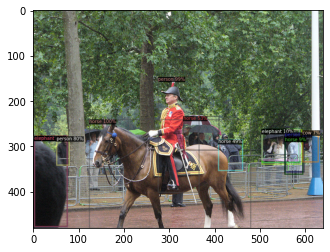

In [8]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("coco_2017_train"))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

## Download and deploy coco2017 dataset

In [9]:
%cd /content

/content


In [10]:
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!mkdir -p /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco
!unzip annotations_trainval2017.zip -d /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/

Archive:  annotations_trainval2017.zip
  inflating: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/annotations/instances_train2017.json  
  inflating: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/annotations/instances_val2017.json  
  inflating: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/annotations/captions_train2017.json  
  inflating: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/annotations/captions_val2017.json  
  inflating: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/annotations/person_keypoints_train2017.json  
  inflating: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/annotations/person_keypoints_val2017.json  


In [11]:
!wget -q http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000259556.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000381931.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000569592.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000229396.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000488990.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000348684.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000234031.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000563584.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/coco/train2017/000000276069.jpg  
 extracting: /usr/local/lib/python3.7/dist-packages/d2go/datasets/co

## Export d2go model trained in coco2017 to torchscript_int8

In [12]:
!cd /usr/local/lib/python3.7/dist-packages/d2go/ && d2go.exporter --config-file configs/faster_rcnn_fbnetv3a_C4.yaml --predictor-type torchscript_int8@tracing --output-dir ./ MODEL.WEIGHTS https://mobile-cv.s3-us-west-2.amazonaws.com/d2go/models/246823121/model_0479999.pth

ストリーミング出力は最後の 5000 行に切り捨てられました。
    POOLER_TYPE: ROIAlignV2
  RPN:
    BATCH_SIZE_PER_IMAGE: 256
    BBOX_REG_LOSS_TYPE: smooth_l1
    BBOX_REG_LOSS_WEIGHT: 1.0
    BBOX_REG_WEIGHTS: (1.0, 1.0, 1.0, 1.0)
    BOUNDARY_THRESH: -1
    CONV_DIMS: [-1]
    HEAD_NAME: FBNetV2RpnHead
    IN_FEATURES: ['trunk3']
    IOU_LABELS: [0, -1, 1]
    IOU_THRESHOLDS: [0.3, 0.7]
    LOSS_WEIGHT: 1.0
    NMS_THRESH: 0.7
    POSITIVE_FRACTION: 0.5
    POST_NMS_TOPK_TEST: 30
    POST_NMS_TOPK_TRAIN: 2000
    PRE_NMS_TOPK_TEST: 1000
    PRE_NMS_TOPK_TRAIN: 2000
    SMOOTH_L1_BETA: 0.0
  SEM_SEG_HEAD:
    COMMON_STRIDE: 4
    CONVS_DIM: 128
    IGNORE_VALUE: 255
    IN_FEATURES: ['p2', 'p3', 'p4', 'p5']
    LOSS_WEIGHT: 1.0
    NAME: SemSegFPNHead
    NORM: GN
    NUM_CLASSES: 54
  SUBCLASS:
    NUM_LAYERS: 1
    NUM_SUBCLASSES: 0
    SUBCLASS_ID_FETCHER: SubclassFetcher
    SUBCLASS_MAPPING: []
    SUBCLASS_ON: False
  VT_FPN:
    HEADS: 16
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
    LAYERS: 3
   

In [13]:
from typing import List, Dict
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile
import os

predictor_path = "/usr/local/lib/python3.7/dist-packages/d2go/torchscript_int8@tracing/"

class Wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        coco_idx_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                            27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51,
                            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77,
                            78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91]
        self.coco_idx = torch.tensor(coco_idx_list)

    def forward(self, inputs: List[torch.Tensor]):
        x = inputs[0].unsqueeze(0) * 255
        scale = 320.0 / min(x.shape[-2], x.shape[-1])
        x = torch.nn.functional.interpolate(x, scale_factor=scale, mode="bilinear", align_corners=True, recompute_scale_factor=True)
        out = self.model(x[0])
        res : Dict[str, torch.Tensor] = {}
        res["boxes"] = out[0] / scale
        res["labels"] = torch.index_select(self.coco_idx, 0, out[1])
        res["scores"] = out[2]
        return inputs, [res]

orig_model = torch.jit.load(os.path.join(predictor_path, "model.jit"))
wrapped_model = Wrapper(orig_model)
scripted_model = torch.jit.script(wrapped_model)
# scripted_model.save("d2go.pt")
optimized_scripted_module = optimize_for_mobile(scripted_model)
optimized_scripted_module._save_for_lite_interpreter("d2go.ptl")